# 下载与解压CIFAR-10数据集

In [1]:
import urllib.request
url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
filename = url.split('/')[-1]

#下载
import os
if not os.path.isfile(filename):
    print ('正在下载%s'%filename)
    urllib.request.urlretrieve(url,filename)
else:
    print ('%s已被下载'%filename)

#解压
import tarfile
if not os.path.exists('cifar-10-batches-py'):
    print ('正在解压%s'%filename)
    tar=tarfile.open(filename,'r:gz')
    tar.extractall()
    tar.close()
else:
    print ('%s已被解压'%filename)

cifar-10-python.tar.gz已被下载
cifar-10-python.tar.gz已被解压


# 读取训练集和测试集
CIFAR共有60000张图片
50000张作为训练集（【5批】*10000张/批）
10000张作为测试集（【1批】*10000张/批）
每张分辨率为32*32的彩色图片构成一个大小为3072的一维数组,对应着一个label

In [3]:
import numpy as np
import pickle

def load_CIFAR_batch(batchfilename):
    f=open(batchfilename,'rb')
    data_dict=pickle.load(f,encoding='bytes')
    f.close()
    images=data_dict[b'data']
#     print (type(images),images.shape) #<class 'numpy.ndarray'> (10000, 3072)
    labels=data_dict[b'labels']         #list
    labels=np.array(labels)
#     print (type(labels),labels.shape) #<class 'numpy.ndarray'> (10000,)
    
    #把原始数据结构调整为BCWH
    images=images.reshape(10000,3,32,32)
    #把通道数据C移动至最后一个维度，形成tensorflow处理图像数据的结构BWHC
    images=images.transpose(0,2,3,1)
    
    return images,labels

def load_CIFAR_data(foldername):
    images_train=[]
    labels_train=[]
    for i in range(1,5+1):
        batchfilename='{}/data_batch_{}'.format(foldername,i)
        images,labels=load_CIFAR_batch(batchfilename)
        print ('%s已加载完毕'%batchfilename)
        images_train.append(images)
        labels_train.append(labels) 
    Xtrain=np.concatenate(images_train)
    Ytrain=np.concatenate(labels_train)
    
    testbatchfilename='{}/test_batch'.format(foldername)
    Xtest,Ytest=load_CIFAR_batch(testbatchfilename)
    print ('%s已加载完毕'%testbatchfilename)
    
    print ('%s已加载完毕'%foldername)
    return Xtrain,Ytrain,Xtest,Ytest

foldername='cifar-10-batches-py'
Xtrain,Ytrain,Xtest,Ytest=load_CIFAR_data(foldername)

print (Xtrain.shape,Ytrain.shape,Xtest.shape,Ytest.shape)
# (50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)

cifar-10-batches-py/data_batch_1已加载完毕
cifar-10-batches-py/data_batch_2已加载完毕
cifar-10-batches-py/data_batch_3已加载完毕
cifar-10-batches-py/data_batch_4已加载完毕
cifar-10-batches-py/data_batch_5已加载完毕
cifar-10-batches-py/test_batch已加载完毕
cifar-10-batches-py已加载完毕
(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


# 查看label所对应的类别信息
batches.meta contains a Python dictionary object.
label_names是一个含有10个元素的列表，如label_names[0]== "airplane" 等

dict_items([(b'num_cases_per_batch', 10000), (b'label_names', [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']), (b'num_vis', 3072)])

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']

In [4]:
foldername='cifar-10-batches-py/'
with open(os.path.join(foldername,'batches.meta'),'rb') as f:
    label_dict=pickle.load(f,encoding='bytes')
#     print (label_dict.items())
    label_names=label_dict[b'label_names']
    print (label_names)

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


# 输出图像检验是否与标签字典对上了

label: 9 means b'truck'


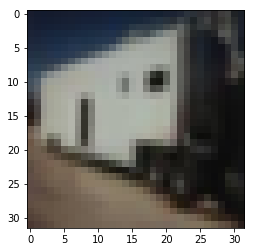

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(Xtrain[1201])
idx=Ytrain[1201]
print ('label:',idx,'means',label_names[idx])

# 图像数据预处理

In [6]:
Xtrain_normalize=Xtrain.astype('float32')/255.0 
Xtest_normalize=Xtest.astype('float32')/255.0
Xtrain_normalize[0][0][0]

array([0.23137255, 0.24313726, 0.24705882], dtype=float32)

# 标签数据预处理

OneHotEncoder(n_values=’auto’,  categorical_features=’all’,  dtype=<class ‘numpy.float64’>,  sparse=True,  handle_unknown=’error’)

sparse表示编码的格式，默认为True，输出的是稀疏的存储格式，即索引加值的形式。
指定 sparse = False则不需要在transform命令后加 toarray() 

In [7]:
from sklearn.preprocessing import OneHotEncoder

encoder=OneHotEncoder(sparse=False)

encoder.fit([[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]])

Ytrain_=Ytrain.reshape(-1,1) #(50000，1)
Ytrain_onehot=encoder.transform(Ytrain_) #(50000,10)

Ytest_=Ytest.reshape(-1,1) #(10000,1)
Ytest_onehot=encoder.transform(Ytest_) #(10000,10)

/anaconda3/envs/dayuse/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


在实际应用中，我们更常用方法 fit_transform()，也就是一步到位

encoder=OneHotEncoder(sparse=False)

Ytrain_=Ytrain.reshape(-1,1) #(50000，1)
Ytrain_onehot=encoder.fit_transform(Ytrain_) #(50000,10)

Ytest_=Ytest.reshape(-1,1) #(10000,1)
Ytest_onehot=encoder.fit_transform(Ytest_) #(10000,10)

# 定义共享函数

In [8]:
def weight(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev=0.1),name='W')
def bias(shape):
    return tf.Variable(tf.constant(0.1,shape=shape),name='b')

## 卷积操作
tf.nn.conv2d(input, filter, strides, padding, use_cudnn_on_gpu=None,name=None)

input是4维张量([batch, height, width, in_channels])，类型为float32或float64其一。
filter是卷积核([filter_height, filter_width, in_channels, out_channels])
strides是图像每一维的步长，是一个长度为4的一维向量。
padding定义了元素边框与元素内容之间的空间，"SAME"表示边缘填充; "VALID"表示边缘不填充。

返回一个tensor，即feature map。

In [9]:
def conv2d(x,w):
    return tf.nn.conv2d(x,w,strides=[1,1,1,1],padding='SAME')

## 池化操作
最大池化 tf.nn.max_pool(value, ksize, strides, padding, name=None) 
平均池化 tf.nn.avg_pool(value, ksize, strides, padding, name=None)

value表示需要池化的输入，通常是conv2d所输出的feature map，即4维的张量([batch, height, width, channels])
ksize表示池化窗口的大小，由于一般不在batch和channel上做池化，所以ksize为[1,height, width,1]
strides是图像每一维的步长，是一个长度为4的一维向量。
padding和卷积函数中padding含义一样
name表示该操作的名称

返回一个tensor

In [10]:
def max_pool_2x2(x):
    return tf.nn.max_pool(x,[1,2,2,1],[1,2,2,1],padding='SAME') #步长为2，即原尺寸的长和宽各除以2

<img src='cnn网络结构.png'>

# 定义网络结构

In [12]:
import tensorflow as tf

with tf.name_scope('input_layer'):
    x=tf.placeholder(tf.float32,shape=[None,32,32,3],name='imagesdata')

with tf.name_scope('conv_layer1'):
    W1=weight([3,3,3,32]) #[卷积核宽度，卷积核高度，输入通道数，输出通道数]
    b1=bias([32]) #与输出通道数一致
    conv1=tf.nn.relu(conv2d(x,W1)+b1)

with tf.name_scope('maxpool_layer1'):
    pool1=max_pool_2x2(conv1)

with tf.name_scope('conv_layer2'):
    W2=weight([3,3,32,64])
    b2=bias([64])
    conv2=tf.nn.relu(conv2d(pool1,W2)+b2)

with tf.name_scope('maxpool_layer2'):
    pool2=max_pool_2x2(conv2)
    
with tf.name_scope('fc_layer'):
    #将第2个池化层的64个8X8的图像转化成一维向量，该向量长度为4096
    W3=weight([4096,128])
    b3=bias([128])
    flat=tf.reshape(pool2,[-1,4096])
    h=tf.nn.relu(tf.matmul(flat,W3)+b3)
    h_dropout=tf.nn.dropout(h,keep_prob=0.8)

with tf.name_scope('output_layer'):
    W4=weight([128,10])
    b4=bias([10])
    output=tf.matmul(h_dropout,W4)+b4
    prop=tf.nn.softmax(output)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# 构建模型

In [14]:
with tf.name_scope('optimizer'):
    y=tf.placeholder(tf.float32,shape=[None,10],name='label')
    loss_function=tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=output,labels=y))
    optimizer=tf.train.AdamOptimizer(0.0001).minimize(loss_function)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# 定义准确率

In [16]:
with tf.name_scope('evaluation'):
    comparison=tf.cast(tf.equal(tf.argmax(prop,1),tf.argmax(y,1)),tf.float32)
    accuracy=tf.reduce_mean(comparison)

# 设置超参

In [23]:
epochs=10
batchsize=50
iterations=int(len(Xtrain)/batchsize)

In [24]:
epoch=tf.Variable(0,name='epoch',trainable=False)

# 记录运行时间

In [25]:
from time import time
starttime=time()

# 启动会话

In [26]:
sess=tf.Session()
init=tf.global_variables_initializer()
sess.run(init)

# 断点续训

In [27]:
import os

ckpt_dir='ckpt_dir/'
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

saver=tf.train.Saver(max_to_keep=1) # max_to_keep 参数用来设置保存模型的个数，默认为5，保存最近的5个模型。如果你想每训练一代就保存一次模型，可将 max_to_keep设置为None或者0。

ckpt=tf.train.get_checkpoint_state(ckpt_dir) #ckpt=tf.train.latest_checkpoint(ckpt_dir)

if ckpt:
    saver.restore(sess, ckpt) #从已保存的模型中读取参数!
else:
    print ('Training from scratch')
    
start=sess.run(epoch)
print ('Training starts from %d epoch'%(start+1))

Training from scratch
Training starts from 1 epoch


# 迭代训练

In [28]:
def get_train_batch(num,batchsize):
    return Xtrain_normalize[num*batchsize:(num+1)*batchsize],Ytrain_onehot[num*batchsize:(num+1)*batchsize]

losslist=[]
acclist=[]

for ep in range(start,epochs):
    for iteration in range(iterations):
        xs,ys=get_train_batch(iteration,batchsize)
        sess.run(optimizer,feed_dict={x:xs,y:ys})
    
    loss,acc=sess.run([loss_function,accuracy],feed_dict={x:xs,y:ys})
    losslist.append(loss)
    acclist.append(acc)
    
    print ('when epoch=%d'%(ep+1),'loss=%.4f'%loss,'acc=%.4f'%acc)
    
    if (ep+1)%5==0: #每经过5轮训练，存储一次模型
        saver.save(sess,os.path.join(ckpt_dir,
                                     'model_{:06d}.ckpt'.format(ep+1)))

saver.save(sess,os.path.join(ckpt_dir,'model.ckpt')) #所有训练结束后，存储模型
print ('Model saved')

when epoch=1 loss_val=1.9623 acc_val=0.3000
when epoch=2 loss_val=1.8320 acc_val=0.3600
when epoch=3 loss_val=1.8675 acc_val=0.3800
when epoch=4 loss_val=1.7255 acc_val=0.4600
when epoch=5 loss_val=1.7613 acc_val=0.4000
when epoch=6 loss_val=1.5703 acc_val=0.4800
when epoch=7 loss_val=1.5954 acc_val=0.4000
when epoch=8 loss_val=1.5599 acc_val=0.4400
when epoch=9 loss_val=1.5567 acc_val=0.4800
when epoch=10 loss_val=1.5163 acc_val=0.4600
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Model saved


In [29]:
print ('Train finished takes:',time()-starttime)

Train finished takes: 5484.909717082977


# 可视化损失值和准确率

Text(0, 0.5, 'accuracy')

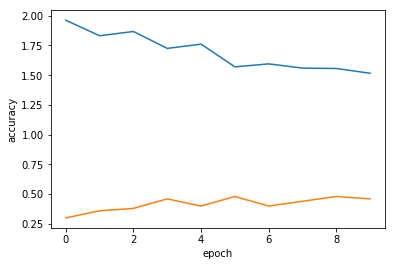

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(losslist)
plt.xlabel('epoch')
plt.ylabel('loss')

plt.plot(acclist)
plt.xlabel('epoch')
plt.ylabel('accuracy')

# 计算测试集上的准确率

In [32]:
test_acc_sum=0.0
for i in range(int(len(Xtest_normalize)/batchsize)):
    test_image_batch=Xtest_normalize[i*batchsize:(i+1)*batchsize]
    test_label_batch=Ytest_onehot[i*batchsize:(i+1)*batchsize]
    test_batch_acc=sess.run(accuracy,feed_dict={x:test_image_batch,y:test_label_batch})
    test_acc_sum+=test_batch_acc
test_acc_average=test_acc_sum/float(len(Xtest_normalize)/batchsize)
print ('Test average accuracy:{:.4f}'.format(test_acc_average))

Test average accuracy:0.6012


# 利用模型进行预测与可视化

In [35]:
test_prop=sess.run(prop,feed_dict={x:Xtest_normalize[:10]})
test_pred=sess.run(tf.argmax(test_prop,1))

test_label=sess.run(tf.argmax(y,axis=1),feed_dict={y:Ytest_onehot[:10]})
print (test_pred)
print (test_label)

[3 8 9 0 6 6 1 6 3 1]
[3 8 8 0 6 6 1 6 3 1]


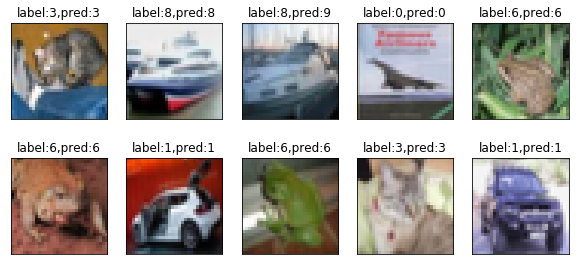

In [37]:
def plot_images_labels(imgs,labels,preds,index=0,num=10):
    fig=plt.figure(figsize=(10,12))
    for i in range(num):
        plt.subplot(5,5,i+1)
        plt.imshow(imgs[index+i].reshape(32,32,3))
        plt.title('label:{},pred:{}'.format(labels[i],preds[i]),fontsize=12)
        plt.xticks([])
        plt.yticks([])
    plt.show()

plot_images_labels(Xtest_normalize,test_label,test_pred)